# Import data_utils

In [1]:
from climsim_utils.data_utils import *

# Instantiate class

In [2]:
grid_path = '../grid_info/ClimSim_low-res_grid-info.nc'
norm_path = '../preprocessing/normalizations/'

grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset(norm_path + 'inputs/input_mean.nc')
input_max = xr.open_dataset(norm_path + 'inputs/input_max.nc')
input_min = xr.open_dataset(norm_path + 'inputs/input_min.nc')
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale.nc')

data = data_utils(grid_info = grid_info, 
                  input_mean = input_mean, 
                  input_max = input_max, 
                  input_min = input_min, 
                  output_scale = output_scale)

# set variables to V1 subset
data.set_to_v1_vars()

# Load training and validation data

The .npy files shown below were created using the `create_npy_data_splits.ipynb` notebook in the preprocessing folder.

In [8]:
# Change this path to your own
data_path = '/gws/nopw/j04/iecdt/bstanleyclamp/climsim_data/subsampled_low_res/'

train_input_path = data_path + 'train_input.npy'
train_target_path = data_path + 'train_target.npy'
val_input_path = data_path + 'val_input.npy'
val_target_path = data_path + 'val_target.npy'


data.input_train = data.load_npy_file(train_input_path)
data.target_train = data.load_npy_file(train_target_path)
data.input_val = data.load_npy_file(val_input_path)
data.target_val = data.load_npy_file(val_target_path)

# Reducing data

In [4]:
test_with_reduced_data = True
grid_columns = 384
reduced_data_quantity = grid_columns * 100 


In [ ]:

if test_with_reduced_data:
    # Reducing data
    data.input_train = data.input_train[:reduced_data_quantity]
    data.target_train = data.target_train[:reduced_data_quantity]
    data.input_val = data.input_val[:reduced_data_quantity]
    data.target_val = data.target_val[:reduced_data_quantity]

In [10]:
print(f'Training data shape: {data.input_train.shape}, {data.target_train.shape}')

Training data shape: (38400, 124), (38400, 128)


In [5]:
# Optional fake data for testing purposes
input_dim = 124
output_dim = 128
data.input_train = np.random.rand(reduced_data_quantity, input_dim)
data.target_train = np.random.rand(reduced_data_quantity, output_dim)
data.input_val = np.random.rand(reduced_data_quantity, input_dim)
data.target_val = np.random.rand(reduced_data_quantity, output_dim)

# Train models

### Train constant prediction model

$\hat{y} = E[y_{train}]$

In [6]:
const_model = data.target_train.mean(axis = 0)

### Train multiple linear regression model

$\beta = {(X_{train}^TX_{train})}^{-1}X_{train}^Ty_{train}$

$\hat{y} = X_{input} \beta$

where $X_{train}$ and $X_{input}$ correspond to the training data and the input data you would like to inference on, respectively. $X_{train}$ and $X_{input}$ both have a column of ones concatenated to the feature space for the bias.


##### adding bias unit

In [7]:
X = data.input_train
bias_vector = np.ones((X.shape[0], 1))
X = np.concatenate((X, bias_vector), axis=1)

##### create model

In [8]:
mlr_weights = np.linalg.inv(X.transpose()@X)@X.transpose()@data.target_train

### Train your models here

In [9]:
### 
# train your model here
###

# Evaluate on validation data

### Set pressure grid

In [10]:
data.set_pressure_grid(data_split = 'val')

### Load predictions

In [11]:
# Constant Prediction
const_pred_val = np.repeat(const_model[np.newaxis, :], data.target_val.shape[0], axis = 0)
print(const_pred_val.shape)

# Multiple Linear Regression
X_val = data.input_val
bias_vector_val = np.ones((X_val.shape[0], 1))
X_val = np.concatenate((X_val, bias_vector_val), axis=1)
mlr_pred_val = X_val@mlr_weights
print(mlr_pred_val.shape)

# Load your prediction here

# Load predictions into data_utils object
data.model_names = ['const', 'mlr'] # add names of your models here
preds = [const_pred_val, mlr_pred_val] # add your custom predictions here
data.preds_val = dict(zip(data.model_names, preds))

(38400, 128)
(38400, 128)


### Weight predictions and target

1. Undo output scaling

2.  Weight vertical levels by dp/g

3. Weight horizontal area of each grid cell by a[x]/mean(a[x])

4. Convert units to a common energy unit

In [12]:
data.reweight_target(data_split = 'val')
data.reweight_preds(data_split = 'val')

### Set and calculate metrics

In [13]:
data.metrics_names = ['MAE', 'RMSE', 'R2', 'bias']
data.create_metrics_df(data_split = 'val')

### Create plots

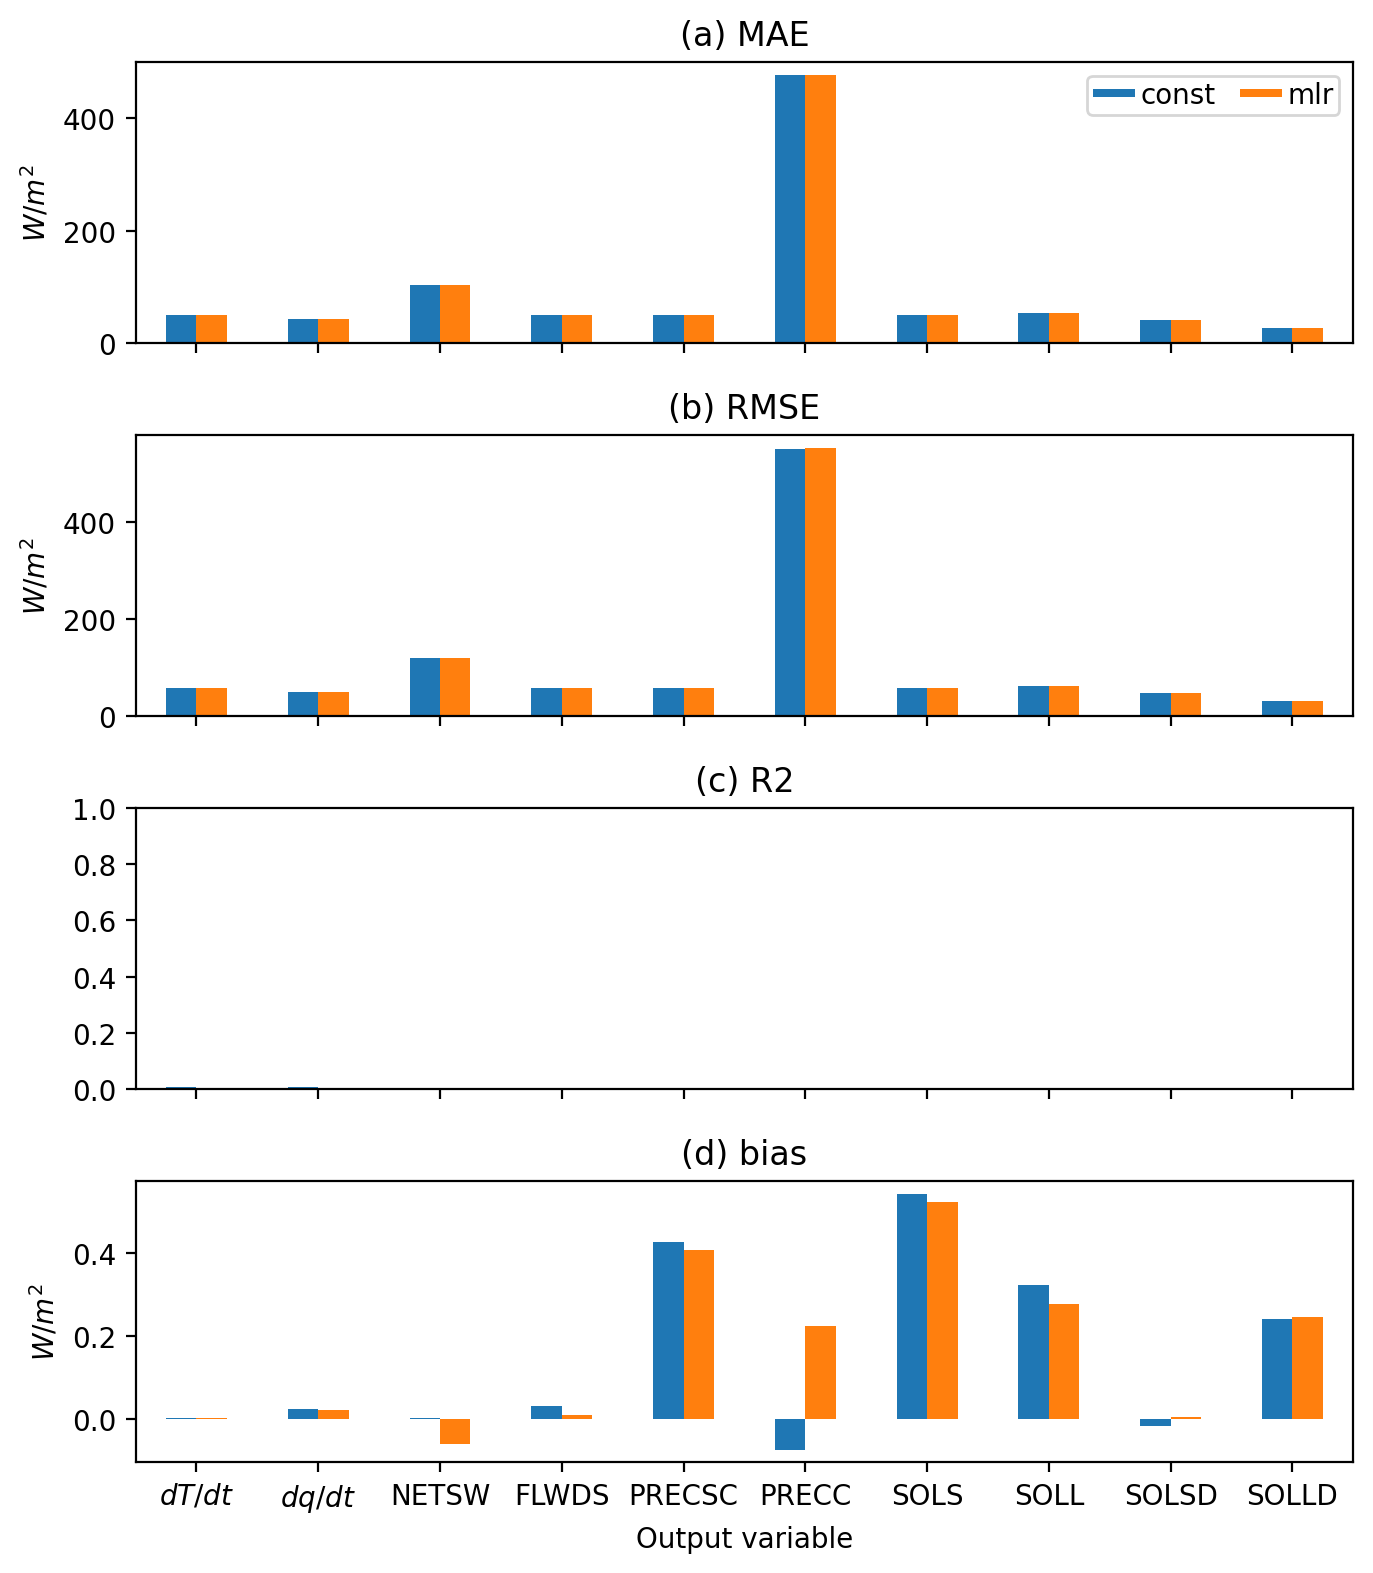

In [14]:
# set plotting settings
%config InlineBackend.figure_format = 'retina'
letters = string.ascii_lowercase

# create custom dictionary for plotting
dict_var = data.metrics_var_val
plot_df_byvar = {}
for metric in data.metrics_names:
    plot_df_byvar[metric] = pd.DataFrame([dict_var[model][metric] for model in data.model_names],
                                               index=data.model_names)
    plot_df_byvar[metric] = plot_df_byvar[metric].rename(columns = data.var_short_names).transpose()

# plot figure
fig, axes = plt.subplots(nrows  = len(data.metrics_names), sharex = True)
for i in range(len(data.metrics_names)):
    plot_df_byvar[data.metrics_names[i]].plot.bar(
        legend = False,
        ax = axes[i])
    if data.metrics_names[i] != 'R2':
        axes[i].set_ylabel('$W/m^2$')
    else:
        axes[i].set_ylim(0,1)

    axes[i].set_title(f'({letters[i]}) {data.metrics_names[i]}')
axes[i].set_xlabel('Output variable')
axes[i].set_xticklabels(plot_df_byvar[data.metrics_names[i]].index, \
    rotation=0, ha='center')

axes[0].legend(columnspacing = .9, 
               labelspacing = .3,
               handleheight = .07,
               handlelength = 1.5,
               handletextpad = .2,
               borderpad = .2,
               ncol = 3,
               loc = 'upper right')
fig.set_size_inches(7,8)
fig.tight_layout()

If you trained models with different hyperparameters, use the ones that performed the best on validation data for evaluation on scoring data.

## Evaluate on scoring data

#### Do this at the VERY END (when you have finished tuned the hyperparameters for your  model and are seeking a final evaluation)

### Load scoring data

In [13]:
scoring_input_path = "/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_input.npy"
scoring_target_path = "/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_target.npy"

# path to target input
data.input_scoring = np.load(scoring_input_path)

# path to target output
data.target_scoring = np.load(scoring_target_path)

### Set pressure grid

In [14]:
data.set_pressure_grid(data_split = 'scoring')

### Load predictions

In [15]:
# constant prediction
const_pred_scoring = np.repeat(const_model[np.newaxis, :], data.target_scoring.shape[0], axis = 0)
print(const_pred_scoring.shape)

# multiple linear regression
X_scoring = data.input_scoring
bias_vector_scoring = np.ones((X_scoring.shape[0], 1))
X_scoring = np.concatenate((X_scoring, bias_vector_scoring), axis=1)
mlr_pred_scoring = X_scoring@mlr_weights
print(mlr_pred_scoring.shape)

# Your model prediction here

# Load predictions into object
data.model_names = ['const', 'mlr'] # model name here
preds = [const_pred_scoring, mlr_pred_scoring] # add prediction here
data.preds_scoring = dict(zip(data.model_names, preds))

(1681920, 128)
(1681920, 128)


### Weight predictions and target

1. Undo output scaling

2.  Weight vertical levels by dp/g

3. Weight horizontal area of each grid cell by a[x]/mean(a[x])

4. Convert units to a common energy unit

In [16]:
# weight predictions and target
data.reweight_target(data_split = 'scoring')
data.reweight_preds(data_split = 'scoring')

# set and calculate metrics
data.metrics_names = ['MAE', 'RMSE', 'R2', 'bias']
data.create_metrics_df(data_split = 'scoring')

/ocean/projects/atm200007p/jlin96/ClimSim/climsim_utils/data_utils.py:705: RuntimeWarning: divide by zero encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/ocean/projects/atm200007p/jlin96/ClimSim/climsim_utils/data_utils.py:705: RuntimeWarning: invalid value encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/ocean/projects/atm200007p/jlin96/ClimSim/climsim_utils/data_utils.py:705: RuntimeWarning: divide by zero encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time
/ocean/projects/atm200007p/jlin96/ClimSim/climsim_utils/data_utils.py:705: RuntimeWarning: invalid value encountered in divide
  r_squared = 1 - sq_diff.sum(axis = 0)/tss_time.sum(axis = 0) # sum over time


### Create plots

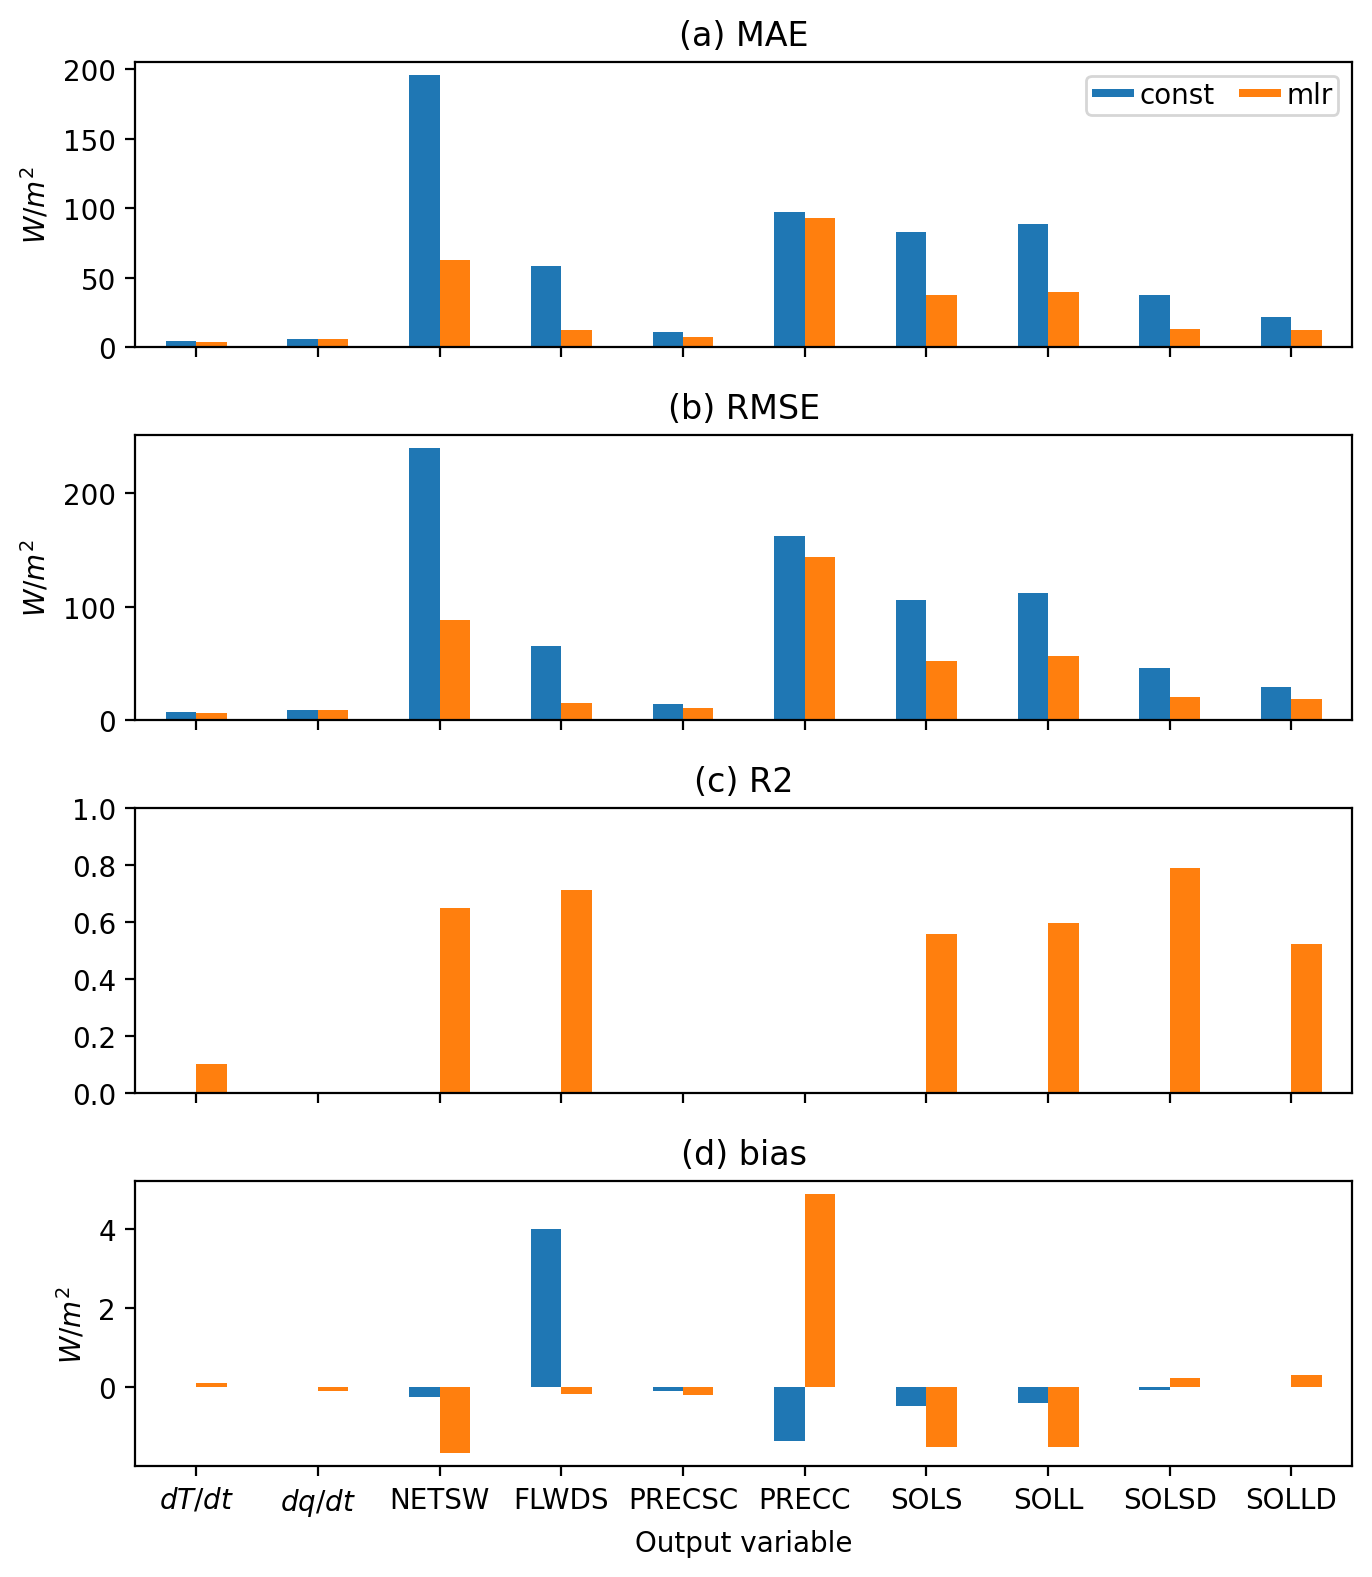

In [17]:
# set plotting settings
%config InlineBackend.figure_format = 'retina'
letters = string.ascii_lowercase

# create custom dictionary for plotting
dict_var = data.metrics_var_scoring
plot_df_byvar = {}
for metric in data.metrics_names:
    plot_df_byvar[metric] = pd.DataFrame([dict_var[model][metric] for model in data.model_names],
                                               index=data.model_names)
    plot_df_byvar[metric] = plot_df_byvar[metric].rename(columns = data.var_short_names).transpose()

# plot figure
fig, axes = plt.subplots(nrows  = len(data.metrics_names), sharex = True)
for i in range(len(data.metrics_names)):
    plot_df_byvar[data.metrics_names[i]].plot.bar(
        legend = False,
        ax = axes[i])
    if data.metrics_names[i] != 'R2':
        axes[i].set_ylabel('$W/m^2$')
    else:
        axes[i].set_ylim(0,1)

    axes[i].set_title(f'({letters[i]}) {data.metrics_names[i]}')
axes[i].set_xlabel('Output variable')
axes[i].set_xticklabels(plot_df_byvar[data.metrics_names[i]].index, \
    rotation=0, ha='center')

axes[0].legend(columnspacing = .9, 
               labelspacing = .3,
               handleheight = .07,
               handlelength = 1.5,
               handletextpad = .2,
               borderpad = .2,
               ncol = 3,
               loc = 'upper right')
fig.set_size_inches(7,8)
fig.tight_layout()